In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path().cwd().parent.parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_is_fitted, check_array
import statsmodels.api as sm


from analysis.gcp.storage import gcp

pd.set_option('display.max_columns', None)

This notebook will build the initial model for predicting player valuations using the standard stats variables provided by Fbref as our main explanatory variables. 

## Load data

In [2]:
df = gcp.read_df_from_bucket(
    bucket_name='wage_vals_stats', blob_name='standard.csv'
)

[04/13/24 12:39:03] INFO     analysis.gcp.storage - [ MainThread:get_gcp_bucket:27 ] - Getting GCP bucket                                ]8;id=15304;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py\storage.py]8;;\:]8;id=793617;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py#27\27]8;;\

                    INFO     analysis.gcp.storage - [ MainThread:get_gcp_bucket:32 ] - GCP bucket retrieved                              ]8;id=897507;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py\storage.py]8;;\:]8;id=535383;file:///Users/conal/Projects/fpl_app/analytics/analysis/gcp/storage.py#32\32]8;;\

In [3]:
class_df = df.copy()

In [4]:
df.head(2)

,player,squad,age,weekly_wages_euros,annual_wages_euros,season,age_range,continent,player_id,position,country,height,foot,signed_from,signing_fee_euro_mill,market_value_euro_mill,league,signed_year,rk,nation,pos,comp,born,mp,starts,min,90s,goals,assists,goals_assists,non_penalty_goals,penalty_kicks,penalty_kicks_attempted,yellow_cards,red_cards,xg,non_penalty_xg,xag,non_pen_xg_plus_xag,progressive_carries,progressive_passes,progressive_passes_received,goals_per_90,assists_per_90,goals_assists_per_90,non_penalty_goals_per_90,non_penalty_goals_assists_per_90,xg_per_90,xag_per_90,xg_plus_xag_per_90,non_penalty_xg_per_90,non_penalty_xg_plus_xag_per_90,general_pos
0,Alexis Sánchez,Arsenal,28,402897,20950637,2017,25-29,South America,2111.0,Centre-Forward,Chile,169.0,right,FC Barcelona,42.5,70.0,premier_league,2014.0,2214,CHI,"MF,FW",Premier League,1988.0,19,17,1503,16.7,7,3,10,6,1,1,4,0,8.1,7.3,4.9,12.2,50.0,149.0,218.0,0.42,0.18,0.6,0.36,0.54,0.49,0.29,0.78,0.44,0.73,Midfielder
1,Mesut Özil,Arsenal,28,402897,20950637,2017,25-29,Europe,1796.0,Attacking-Midfield,Germany,180.0,left,Real Madrid,47.0,50.0,premier_league,2013.0,1881,GER,"MF,FW",Premier League,1988.0,26,24,2163,24.0,4,8,12,4,0,0,4,0,4.4,4.4,8.7,13.1,136.0,277.0,267.0,0.17,0.33,0.5,0.17,0.50,0.18,0.36,0.55,0.18,0.55,Midfielder


In [5]:
df.shape

(13677, 53)

In [6]:
df.describe()

,age,weekly_wages_euros,annual_wages_euros,season,player_id,height,signing_fee_euro_mill,market_value_euro_mill,signed_year,rk,born,mp,starts,min,90s,goals,assists,goals_assists,non_penalty_goals,penalty_kicks,penalty_kicks_attempted,yellow_cards,red_cards,xg,non_penalty_xg,xag,non_pen_xg_plus_xag,progressive_carries,progressive_passes,progressive_passes_received,goals_per_90,assists_per_90,goals_assists_per_90,non_penalty_goals_per_90,non_penalty_goals_assists_per_90,xg_per_90,xag_per_90,xg_plus_xag_per_90,non_penalty_xg_per_90,non_penalty_xg_plus_xag_per_90
count,13677.000000,1.367700e+04,1.367700e+04,13677.000000,13677.000000,13677.000000,10639.000000,13606.000000,13609.000000,13677.000000,13675.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000
mean,25.698837,4.815287e+04,2.503949e+06,2019.997733,2413.083644,182.514879,9.628881,11.511315,2018.346094,1371.962053,1993.958464,19.468231,14.845068,1330.401038,14.782248,1.845726,1.295752,3.141478,1.671565,0.174161,0.222344,2.712291,0.128171,1.876077,1.699817,1.321801,3.022416,24.265418,52.486795,51.861511,0.120394,0.083333,0.203736,0.111200,0.194519,0.131610,0.089835,0.221422,0.122049,0.211865
std,4.373440,7.638336e+04,3.971935e+06,1.957783,1601.270057,6.590985,17.196836,17.041625,3.056059,799.200712,4.748990,10.807299,10.944243,942.954437,10.477083,3.393283,2.030923,4.799819,2.981476,0.758550,0.894429,2.681232,0.377248,3.038701,2.620606,1.765849,3.958540,29.008931,53.714195,65.661538,0.301984,0.186163,0.372806,0.292418,0.363445,0.201597,0.143707,0.268915,0.188780,0.257214
min,15.000000,1.000000e+00,4.200000e+01,2017.000000,1.000000,162.000000,0.000000,0.100000,2000.000000,1.000000,1977.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,1.038500e+04,5.400000e+05,2018.000000,1090.000000,178.000000,0.400000,2.000000,2017.000000,680.000000,1991.000000,11.000000,5.000000,506.000000,5.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.100000,0.100000,0.100000,0.400000,4.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.050000,0.020000,0.050000
50%,25.000000,2.403800e+04,1.250000e+06,2020.000000,2180.000000,183.000000,3.500000,5.000000,2019.000000,1364.000000,1994.000000,19.000000,14.000000,1214.000000,13.500000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.800000,0.700000,0.700000,1.600000,14.000000,37.000000,25.000000,0.030000,0.000000,0.110000,0.030000,0.100000,0.060000,0.060000,0.140000,0.060000,0.140000
75%,29.000000,5.769200e+04,3.000000e+06,2022.000000,3560.000000,187.000000,12.000000,14.500000,2021.000000,2055.000000,1997.000000,29.000000,24.000000,2067.000000,23.000000,2.000000,2.000000,4.000000,2.000000,0.000000,0.000000,4.000000,0.000000,2.200000,2.100000,1.900000,4.000000,35.000000,79.000000,77.000000,0.160000,0.120000,0.300000,0.150000,0.290000,0.180000,0.130000,0.320000,0.160000,0.310000
max,42.000000,1.384615e+06,7.200000e+07,2023.000000,6306.000000,202.000000,500.000000,200.000000,2023.000000,2920.000000,2007.000000,38.000000,38.000000,3420.000000,38.000000,41.000000,21.000000,49.000000,33.000000,14.000000,15.000000,17.000000,4.000000,33.200000,29.300000,20.000000,37.900000,276.000000,424.000000,674.000000,22.500000,11.250000,22.500000,22.500000,22.500000,7.840000,7.820000,7.840000,7.840000,7.840000


Data Distributions

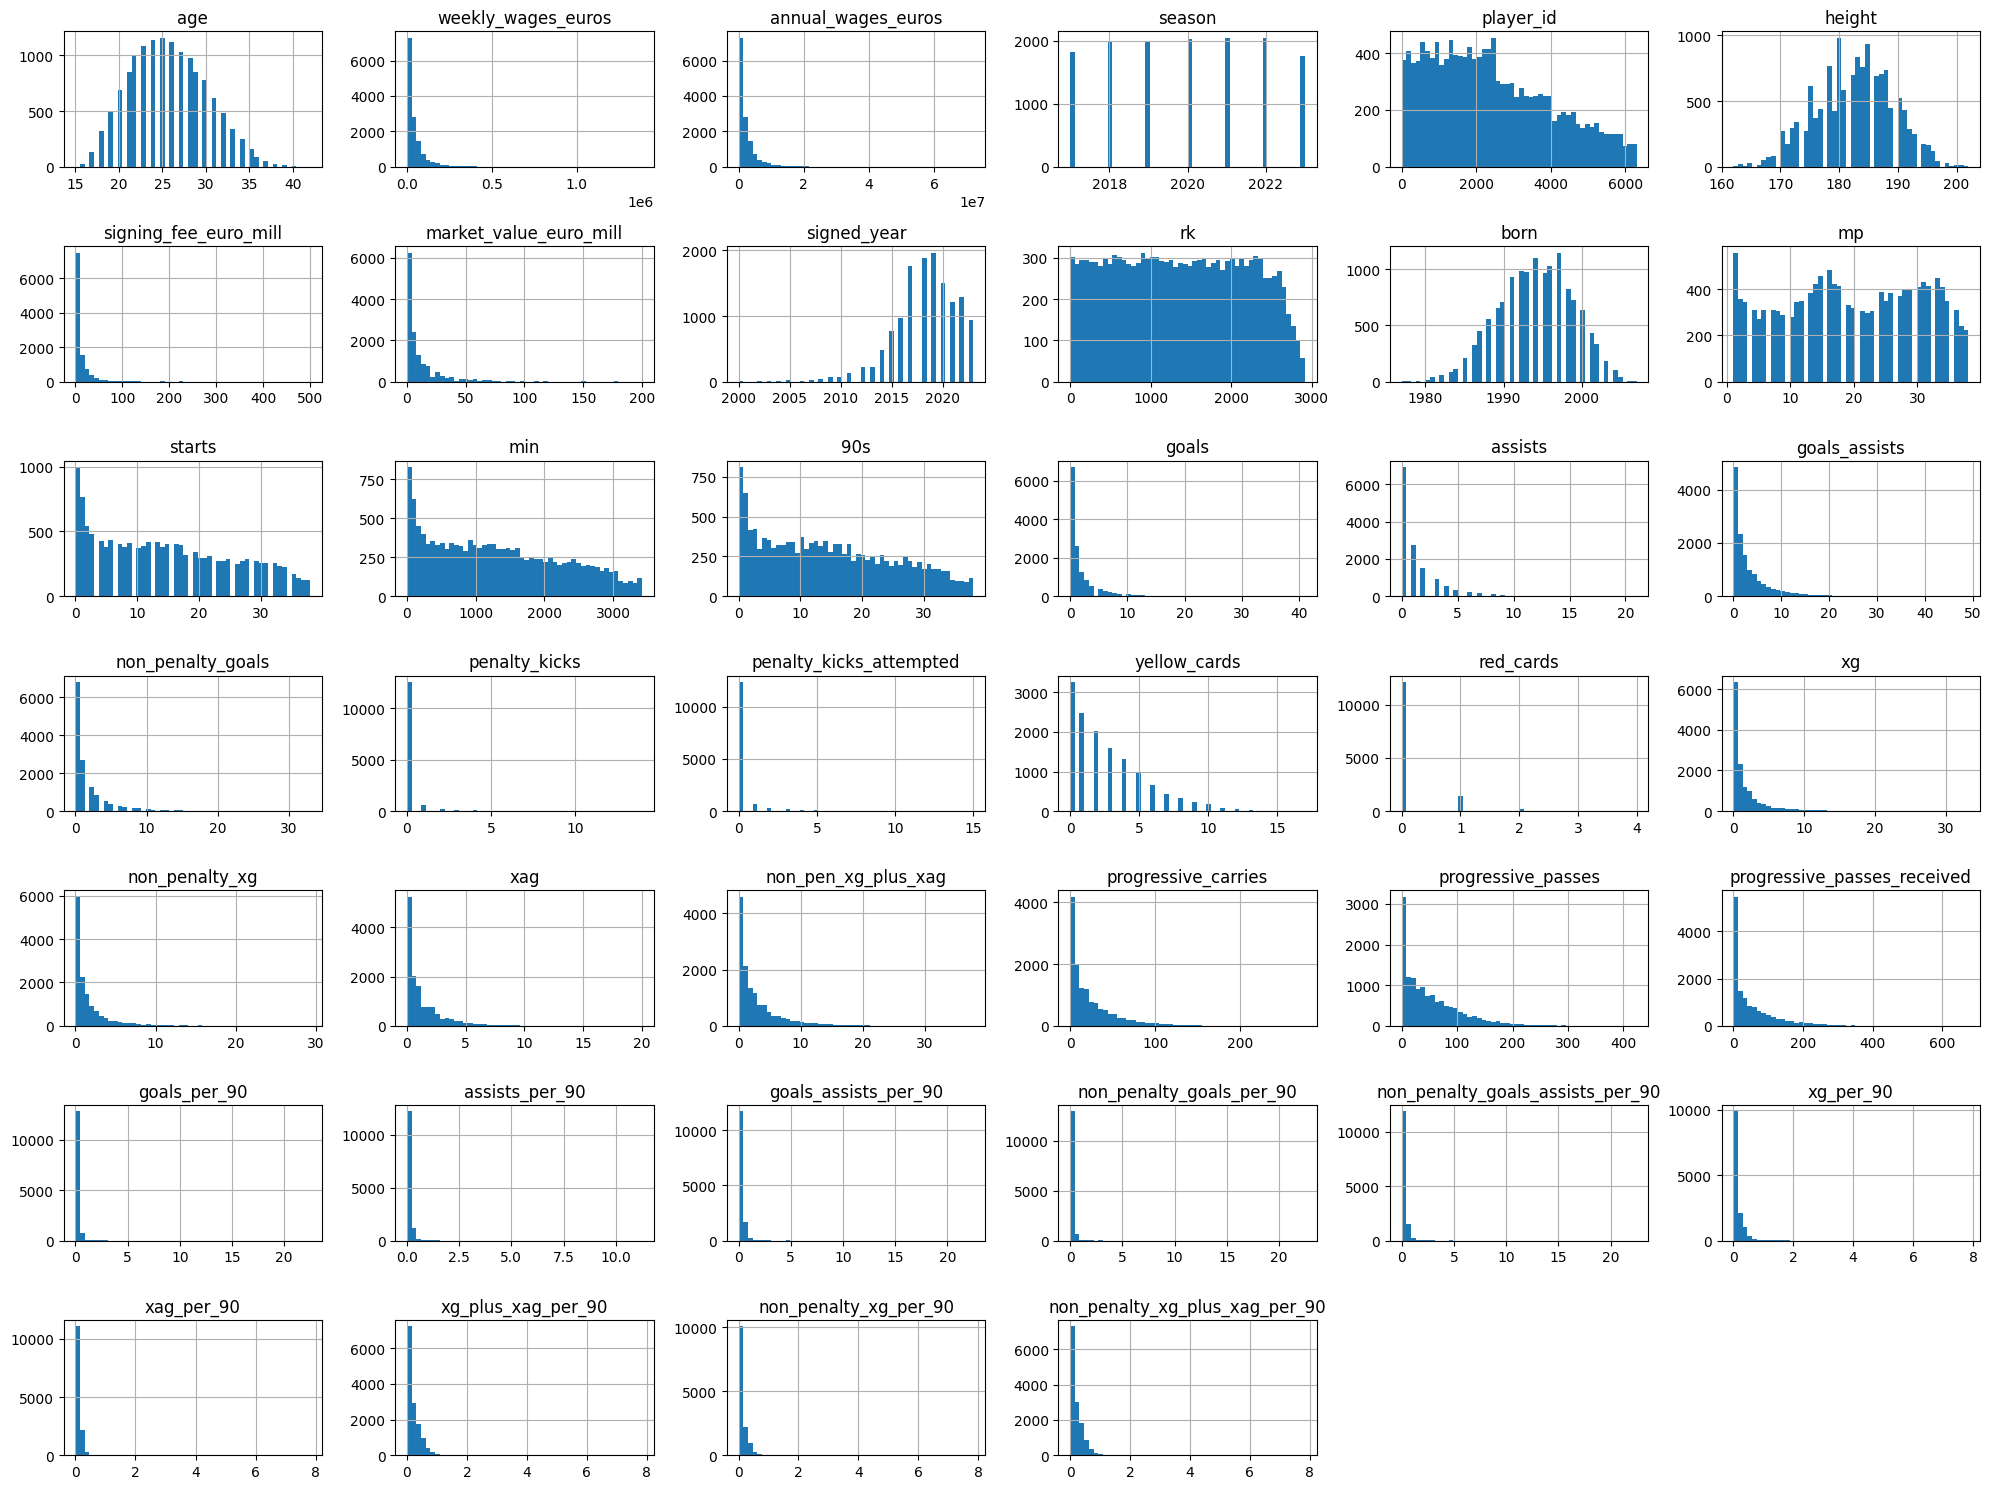

In [7]:
df.select_dtypes(include='number').hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

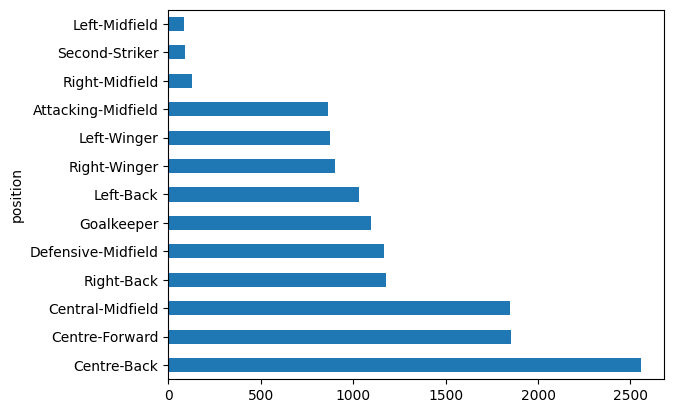

In [8]:
df['position'].value_counts().plot(kind='barh')
plt.show()

## Preprocessing

## Drop variables

Don't need id columns for model building so they can be removed

In [9]:
cols_to_drop = ["player_id", "rk", "general_pos", "pos", "nation", "comp", "born", 'annual_wages_euros', 'player']
df = df.drop(cols_to_drop, axis=1)

## Missing Values

In [10]:
# percentage of missing values
missing_vals = pd.DataFrame()
missing_vals.loc[:, 'missing_count'] = df.isnull().sum().sort_values(ascending=False).head(25)
missing_vals.loc[:, 'missing_pct'] = (df.isnull().sum().sort_values(ascending=False) / df.shape[0] * 100).round(2).head(25)

missing_vals.sort_values(by='missing_pct', ascending=False)

,missing_count,missing_pct
signing_fee_euro_mill,3038,22.21
signed_from,73,0.53
market_value_euro_mill,71,0.52
signed_year,68,0.50
foot,28,0.20
progressive_passes_received,8,0.06
non_penalty_xg_per_90,8,0.06
xg_plus_xag_per_90,8,0.06
xag_per_90,8,0.06
xg_per_90,8,0.06


In [11]:
def create_youth_player_col(x: pd.Series) -> bool:
    if pd.isna(x["squad"]) or pd.isna(x["signed_from"]):
        return 'False'

    squad_words = x["squad"].split()  # Split squad name into words

    for word in squad_words:
        if word in x["signed_from"]:
            return 'True'
        else:
            return 'False'

In [12]:
df['is_youth_player'] = df.apply(create_youth_player_col, axis=1)

In [13]:
df['is_youth_player'].value_counts()

is_youth_player
False    11712
True      1965
Name: count, dtype: int64

In [14]:
df.loc[df['is_youth_player'] == True, 'signing_fee_euro_mill'].isnull().sum()

0

Most of the null signings fees are a result of a player being signed from the youth team - therefore we can impute this with 0

In [15]:
df.loc[df['is_youth_player'] == True, 'signing_fee_euro_mill'] = 0

In [16]:
df.loc[:, "signing_fee_euro_mill"] = df["signing_fee_euro_mill"].fillna(
    df.groupby(["league", "age"])["signing_fee_euro_mill"].transform(
        "median"
    )
)

For the remaining values we can impute with median signing fee by league and age

In [17]:
df['signing_fee_euro_mill'].isnull().sum()

6

In [18]:
df.isnull().sum().sort_values(ascending=False).head(20)

signed_from                       73
market_value_euro_mill            71
signed_year                       68
foot                              28
progressive_passes_received        8
progressive_carries                8
non_pen_xg_plus_xag                8
xag                                8
non_penalty_xg                     8
xg                                 8
xg_per_90                          8
xag_per_90                         8
xg_plus_xag_per_90                 8
non_penalty_xg_per_90              8
non_penalty_xg_plus_xag_per_90     8
progressive_passes                 8
signing_fee_euro_mill              6
squad                              0
goals_per_90                       0
assists_per_90                     0
dtype: int64

In [19]:
df.loc[:, 'market_value_euro_mill'] = df['market_value_euro_mill'].fillna(df.groupby(['league', 'age'])['market_value_euro_mill'].transform('median'))

In [20]:
df.loc[df['signed_from'].isnull(), 'signed_from'] = 'Unknown'

In [21]:
df.isnull().sum().sort_values(ascending=False).head(20)

signed_year                       68
foot                              28
xg                                 8
progressive_carries                8
progressive_passes_received        8
non_pen_xg_plus_xag                8
xag                                8
non_penalty_xg                     8
progressive_passes                 8
xg_per_90                          8
xag_per_90                         8
xg_plus_xag_per_90                 8
non_penalty_xg_per_90              8
non_penalty_xg_plus_xag_per_90     8
signing_fee_euro_mill              6
red_cards                          0
squad                              0
assists_per_90                     0
goals_per_90                       0
penalty_kicks_attempted            0
dtype: int64

In [22]:
df.loc[df['signed_year'].isnull(), 'signed_year'] = df['season']

In [23]:
df.isnull().sum().sort_values(ascending=False).head(20)

foot                              28
progressive_passes                 8
non_penalty_xg_plus_xag_per_90     8
non_penalty_xg_per_90              8
xg_plus_xag_per_90                 8
xag_per_90                         8
xg_per_90                          8
xg                                 8
non_penalty_xg                     8
xag                                8
non_pen_xg_plus_xag                8
progressive_carries                8
progressive_passes_received        8
signing_fee_euro_mill              6
red_cards                          0
squad                              0
goals_per_90                       0
assists_per_90                     0
penalty_kicks_attempted            0
goals_assists_per_90               0
dtype: int64

In [24]:
# impute the stats with the median for age, position, and league
df.loc[:, 'foot'] = df['foot'].fillna(df['foot'].mode()[0])   

In [25]:
def custom_fillna(df: pd.DataFrame, groupby: list[str], column: str) -> pd.DataFrame:
    return df[column].fillna(df.groupby(groupby)[column].transform('median'))

In [26]:
nulls = df.isnull().sum().sort_values(ascending=False)
nulls = nulls[nulls > 0]

In [27]:
nulls.index

Index(['progressive_carries', 'non_penalty_xg_plus_xag_per_90',
       'non_penalty_xg_per_90', 'xg_plus_xag_per_90', 'xag_per_90',
       'xg_per_90', 'xg', 'non_penalty_xg', 'xag', 'non_pen_xg_plus_xag',
       'progressive_passes_received', 'progressive_passes',
       'signing_fee_euro_mill'],
      dtype='object')

In [28]:
for col in nulls.index:
    df.loc[:, col] = custom_fillna(df, ['league', 'age', 'position'], col)

In [29]:
df.isnull().sum().sort_values(ascending=False).head(2)

signing_fee_euro_mill    6
goals_per_90             0
dtype: int64

## Split data into Train, Validation, and Test sets

Stratify split based on player position and hold season 2023 data as the validation and test set. We do this because valuations change over the years so we do not want to randomly split the data, we want to use past data to predict on future data i.e. past data (2017-2022), future data (2023)

In [30]:
train_set = df.loc[df['season'] != 2023]
season_2023 = df.loc[df['season'] == 2023]
valid_set, test_set = train_test_split(season_2023, test_size=0.5, stratify=season_2023['position'], random_state=42)


In [31]:
valid_set, test_set = train_test_split(season_2023, test_size=0.5, stratify=season_2023['position'], random_state=42)

In [32]:
# load out data
data_dir = Path().cwd().parent / 'data' / 'processed'
train_set.to_csv(data_dir / 'train_set.csv', index=False)
valid_set.to_csv(data_dir / 'valid_set.csv', index=False)
test_set.to_csv(data_dir / 'test_set.csv', index=False)

In [33]:
# split the data into X and y
X_train = train_set.drop('market_value_euro_mill', axis=1)
y_train = train_set['market_value_euro_mill'].copy()

## Correlations

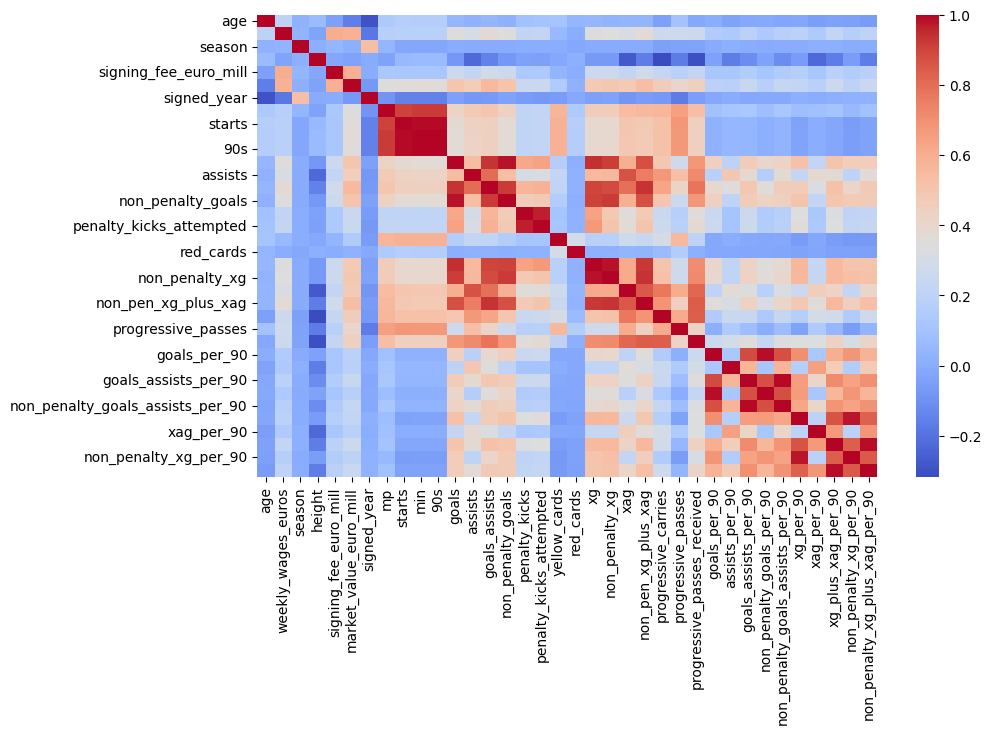

In [34]:
fig = plt.figure(figsize=(10, 6))
sns.heatmap(train_set.corr(numeric_only=True), cmap='coolwarm')
plt.show()

We can get a detailed look here

In [35]:
corrs = train_set.corr(numeric_only=True)
corrs.style.background_gradient(cmap='coolwarm')

,age,weekly_wages_euros,season,height,signing_fee_euro_mill,market_value_euro_mill,signed_year,mp,starts,min,90s,goals,assists,goals_assists,non_penalty_goals,penalty_kicks,penalty_kicks_attempted,yellow_cards,red_cards,xg,non_penalty_xg,xag,non_pen_xg_plus_xag,progressive_carries,progressive_passes,progressive_passes_received,goals_per_90,assists_per_90,goals_assists_per_90,non_penalty_goals_per_90,non_penalty_goals_assists_per_90,xg_per_90,xag_per_90,xg_plus_xag_per_90,non_penalty_xg_per_90,non_penalty_xg_plus_xag_per_90
age,1.000000,0.198514,0.023737,0.059959,-0.045910,-0.159187,-0.294574,0.136701,0.169641,0.166595,0.166597,0.045246,0.021712,0.041193,0.027585,0.094129,0.102536,0.106576,0.042880,0.048346,0.028455,0.036065,0.034888,-0.047767,0.095527,-0.013998,0.003632,-0.035042,-0.013361,-0.009486,-0.024581,-0.020496,-0.050302,-0.041592,-0.044053,-0.060011
weekly_wages_euros,0.198514,1.000000,0.031305,-0.032136,0.601068,0.585475,-0.179397,0.173754,0.180290,0.179763,0.179739,0.350823,0.309243,0.378800,0.344420,0.216761,0.225330,0.057046,0.004842,0.346436,0.340882,0.319583,0.368189,0.261353,0.268380,0.259663,0.148812,0.139203,0.188064,0.131712,0.174841,0.190873,0.143338,0.218815,0.169254,0.203358
season,0.023737,0.031305,1.000000,0.015648,0.042072,0.008299,0.536310,0.042317,-0.019847,-0.021447,-0.021494,-0.002543,-0.005538,-0.004135,-0.004773,0.007377,0.004205,0.006163,-0.013764,-0.004158,-0.005968,-0.004872,-0.006068,-0.047379,-0.037789,-0.031068,-0.003582,0.007966,0.000877,-0.005224,-0.000382,-0.000201,0.017146,0.008480,-0.002513,0.007132
height,0.059959,-0.032136,0.015648,1.000000,-0.020450,-0.037037,-0.004845,-0.037758,0.055185,0.061775,0.061746,-0.075303,-0.228743,-0.149762,-0.075204,-0.041513,-0.046399,-0.015691,0.013060,-0.068428,-0.066710,-0.272506,-0.165718,-0.316235,-0.169947,-0.304815,-0.042087,-0.166618,-0.112742,-0.038121,-0.111228,-0.061821,-0.226211,-0.163672,-0.056789,-0.164291
signing_fee_euro_mill,-0.045910,0.601068,0.042072,-0.020450,1.000000,0.593428,-0.001006,0.126690,0.116478,0.116265,0.116249,0.258220,0.222201,0.276518,0.260636,0.131550,0.134734,0.037751,0.007656,0.259230,0.264414,0.227622,0.276655,0.233527,0.179260,0.224490,0.123671,0.119010,0.157732,0.112893,0.149724,0.169053,0.122074,0.191371,0.157886,0.183605
market_value_euro_mill,-0.159187,0.585475,0.008299,-0.037037,0.593428,1.000000,-0.073112,0.346849,0.361044,0.362464,0.362428,0.500245,0.463841,0.549786,0.506687,0.247871,0.251444,0.150833,0.020599,0.478259,0.487136,0.477031,0.535376,0.459026,0.405836,0.443485,0.189008,0.181912,0.241223,0.173040,0.229353,0.219951,0.178800,0.259343,0.202995,0.247743
signed_year,-0.294574,-0.179397,0.536310,-0.004845,-0.001006,-0.073112,1.000000,-0.088372,-0.147120,-0.149311,-0.149341,-0.048459,-0.076575,-0.066599,-0.039140,-0.063096,-0.069520,-0.063033,-0.008280,-0.047954,-0.036684,-0.084810,-0.062040,-0.069755,-0.169213,-0.053191,-0.016272,0.000785,-0.013048,-0.010481,-0.008205,0.011604,0.005900,0.011717,0.022844,0.019970
mp,0.136701,0.173754,0.042317,-0.037758,0.126690,0.346849,-0.088372,1.000000,0.904600,0.921135,0.921151,0.423980,0.472643,0.499493,0.429341,0.210469,0.224200,0.569375,0.146261,0.456398,0.468972,0.544685,0.553587,0.563962,0.646998,0.536539,0.092272,0.111494,0.128448,0.078854,0.118261,0.076900,0.088999,0.104461,0.057217,0.090775
starts,0.169641,0.180290,-0.019847,0.055185,0.116478,0.361044,-0.147120,0.904600,1.000000,0.994674,0.994667,0.373750,0.434005,0.447635,0.371827,0.211671,0.222936,0.588029,0.169040,0.392736,0.395432,0.496229,0.483280,0.520926,0.679113,0.449321,0.025015,0.044844,0.041645,0.012295,0.031500,-0.033820,0.005845,-0.022404,-0.055387,-0.037885
min,0.166595,0.179763,-0.021447,0.061775,0.116265,0.362464,-0.149311,0.921135,0.994674,1.000000,0.999997,0.370583,0.428805,0.443200,0.368797,0.209400,0.220834,0.585806,0.161951,0.391320,0.394349,0.491557,0.480453,0.518730,0.674966,0.446596,0.026525,0.045264,0.043100,0.013953,0.033091,-0.029792,0.006218,-0.019148,-0.051082,-0.034465


Correlations between market value and explanatory variables

In [36]:
y_corrs = corrs.loc[:,'market_value_euro_mill'].sort_values(ascending=False).reset_index()
y_corrs.style.background_gradient(cmap='coolwarm')

,index,market_value_euro_mill
0,market_value_euro_mill,1.000000
1,signing_fee_euro_mill,0.593428
2,weekly_wages_euros,0.585475
3,goals_assists,0.549786
4,non_pen_xg_plus_xag,0.535376
5,non_penalty_goals,0.506687
6,goals,0.500245
7,non_penalty_xg,0.487136
8,xg,0.478259
9,xag,0.477031


## Distribution of market_value_euro_mill

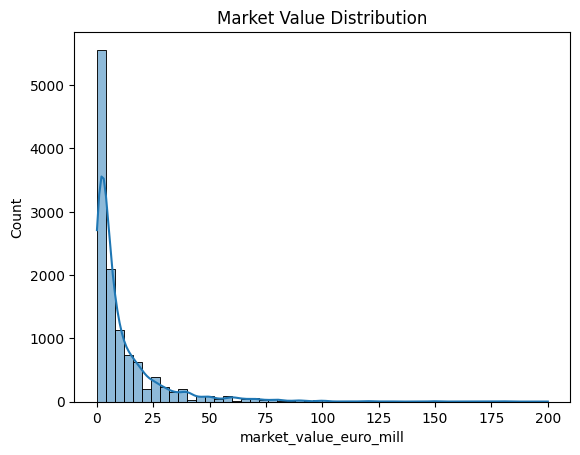

In [37]:
sns.histplot(y_train, bins=50, kde=True)
plt.title('Market Value Distribution')
plt.show()

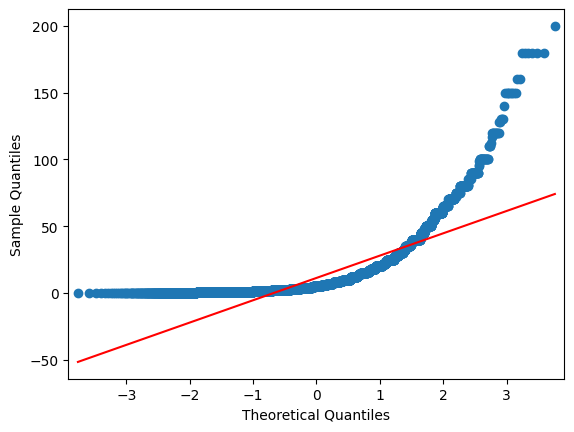

In [38]:
sm.qqplot(y_train, line='s')
plt.show()

Clearly heavily skewed to the right, therefore a log transformation will be needed for our model.

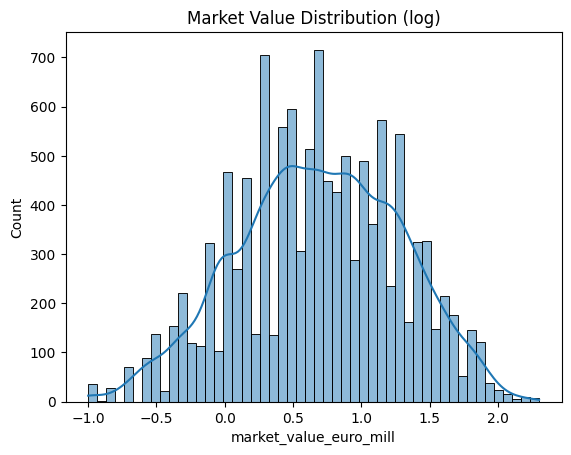

In [39]:
y_log = np.log10(y_train)

sns.histplot(y_log, bins=50, kde=True)
plt.title('Market Value Distribution (log)')
plt.show()

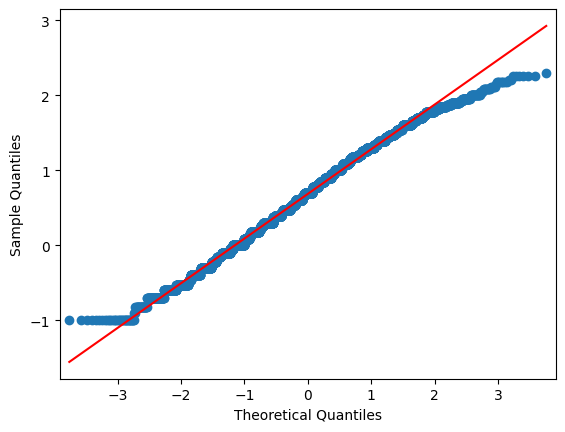

In [40]:
sm.qqplot(y_log, line='s')
plt.show()

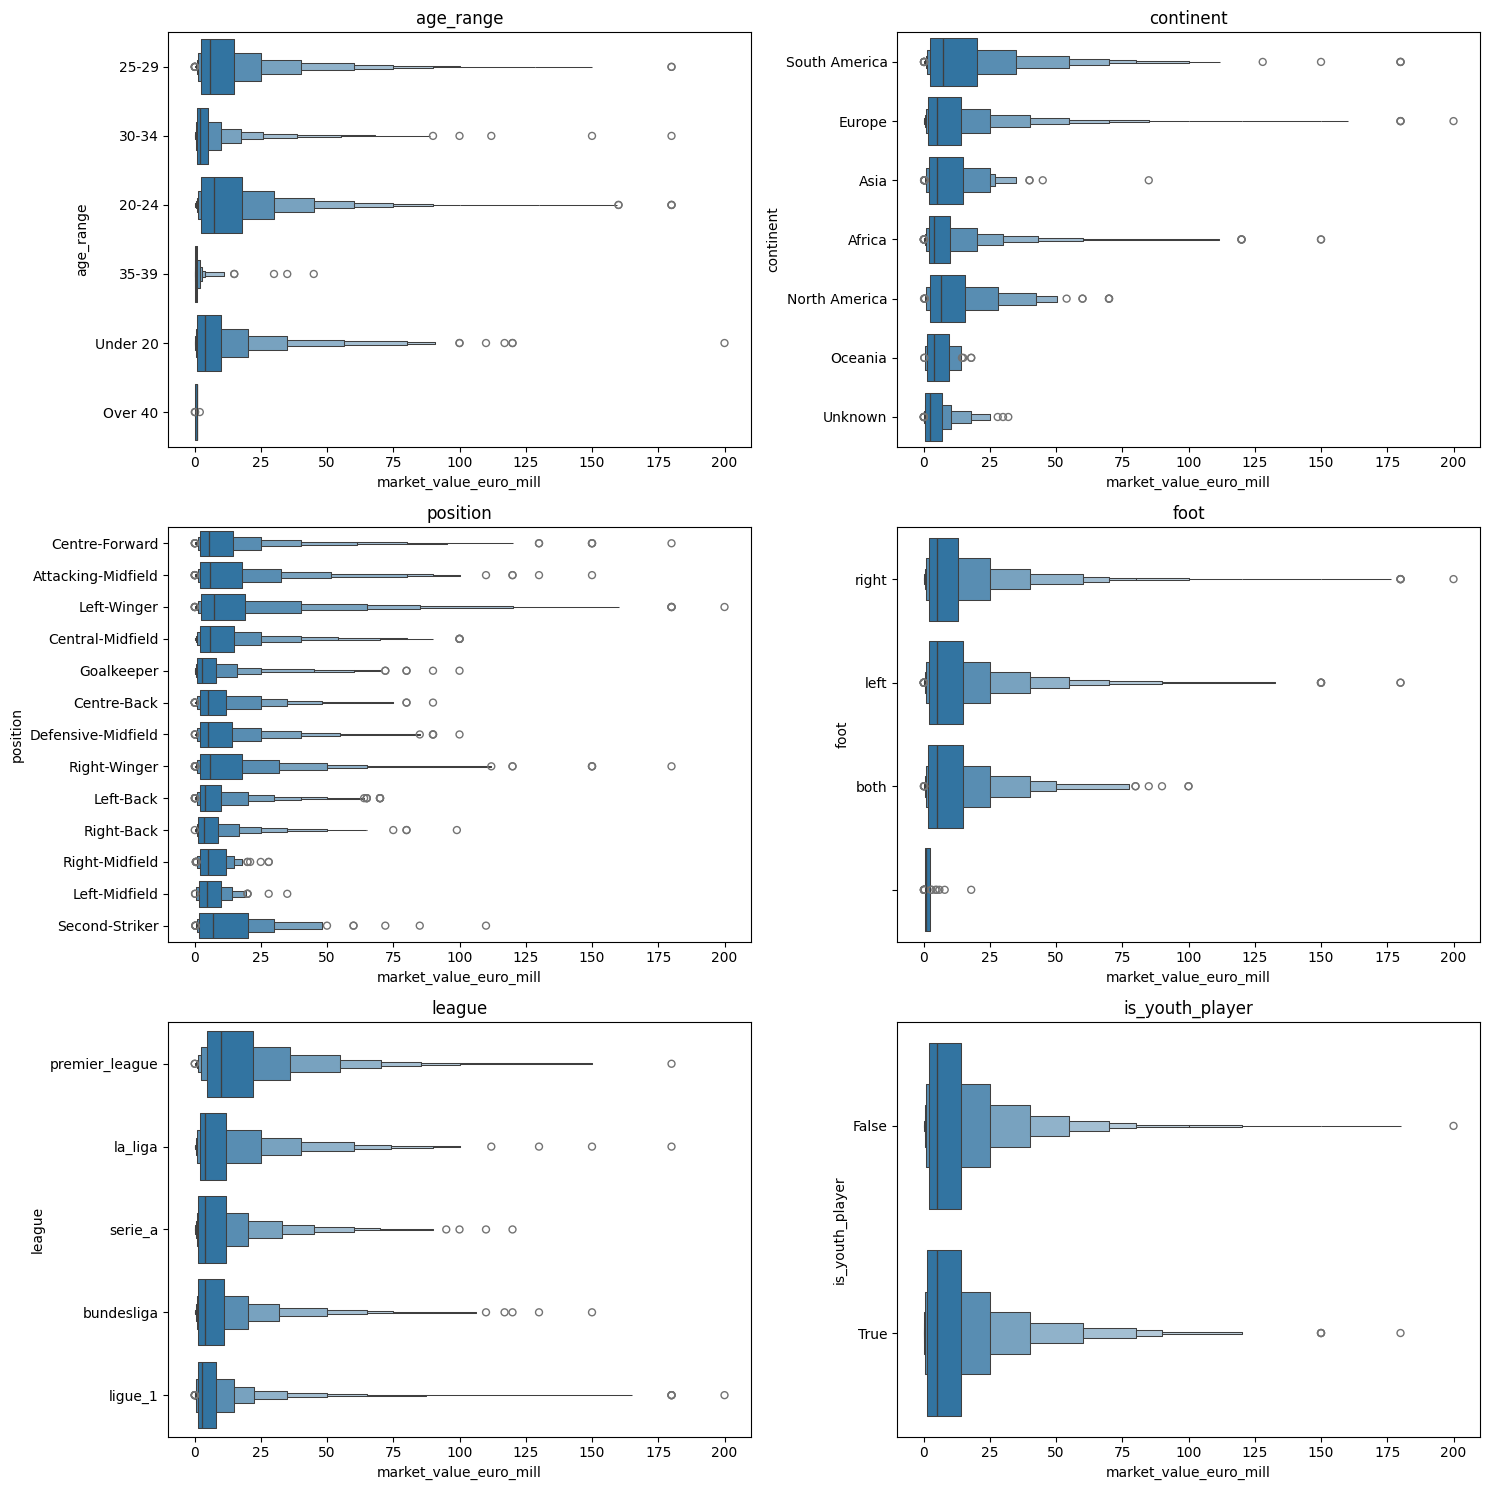

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

cat_cols = train_set.select_dtypes(include='object').columns
exclude_cols = ['player', 'squad', 'country', 'signed_from', 'nation']

cat_cols = [col for col in cat_cols if col not in exclude_cols]

for i in range(len(cat_cols), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])
    
for stat, ax in zip(cat_cols, axes.flatten()):
    sns.boxenplot(y=stat, x='market_value_euro_mill', data=train_set, ax=ax)
    ax.set_title(stat)

plt.tight_layout()
plt.show()

In [42]:
def dists_analysis(df: pd.DataFrame) -> pd.DataFrame:
    dists_df = pd.DataFrame()
    dists_df.loc[:, "skew"] = df.skew(numeric_only=True).sort_values(ascending=False)
    dists_df.loc[:, "kurtosis"] = df.kurtosis(numeric_only=True).sort_values(
        ascending=False
    )
    return dists_df.reset_index().rename(columns={"index": "feature"})

In [43]:
dists_df = dists_analysis(X_train)
skewed_cols = dists_df.loc[dists_df["skew"] > 0.5]['feature'].tolist()
skewed_cols

['non_penalty_goals_per_90',
 'goals_per_90',
 'assists_per_90',
 'non_penalty_goals_assists_per_90',
 'goals_assists_per_90',
 'xag_per_90',
 'non_penalty_xg_per_90',
 'xg_per_90',
 'non_penalty_xg_plus_xag_per_90',
 'signing_fee_euro_mill',
 'xg_plus_xag_per_90',
 'weekly_wages_euros',
 'penalty_kicks',
 'penalty_kicks_attempted',
 'goals',
 'xg',
 'non_penalty_goals',
 'non_penalty_xg',
 'red_cards',
 'goals_assists',
 'assists',
 'non_pen_xg_plus_xag',
 'xag',
 'progressive_carries',
 'progressive_passes_received',
 'progressive_passes',
 'yellow_cards']

In [44]:
X_train.loc[:, skewed_cols] = StandardScaler().fit_transform(X_train[skewed_cols])

In [45]:
dists_df_2 = dists_analysis(X_train)

In [46]:
dists_df_2.head()

,feature,skew,kurtosis
0,non_penalty_goals_per_90,40.223852,2774.498445
1,goals_per_90,36.950768,2461.366793
2,assists_per_90,26.095778,1489.963674
3,non_penalty_goals_assists_per_90,25.322175,1331.240639
4,goals_assists_per_90,23.600630,1203.965509


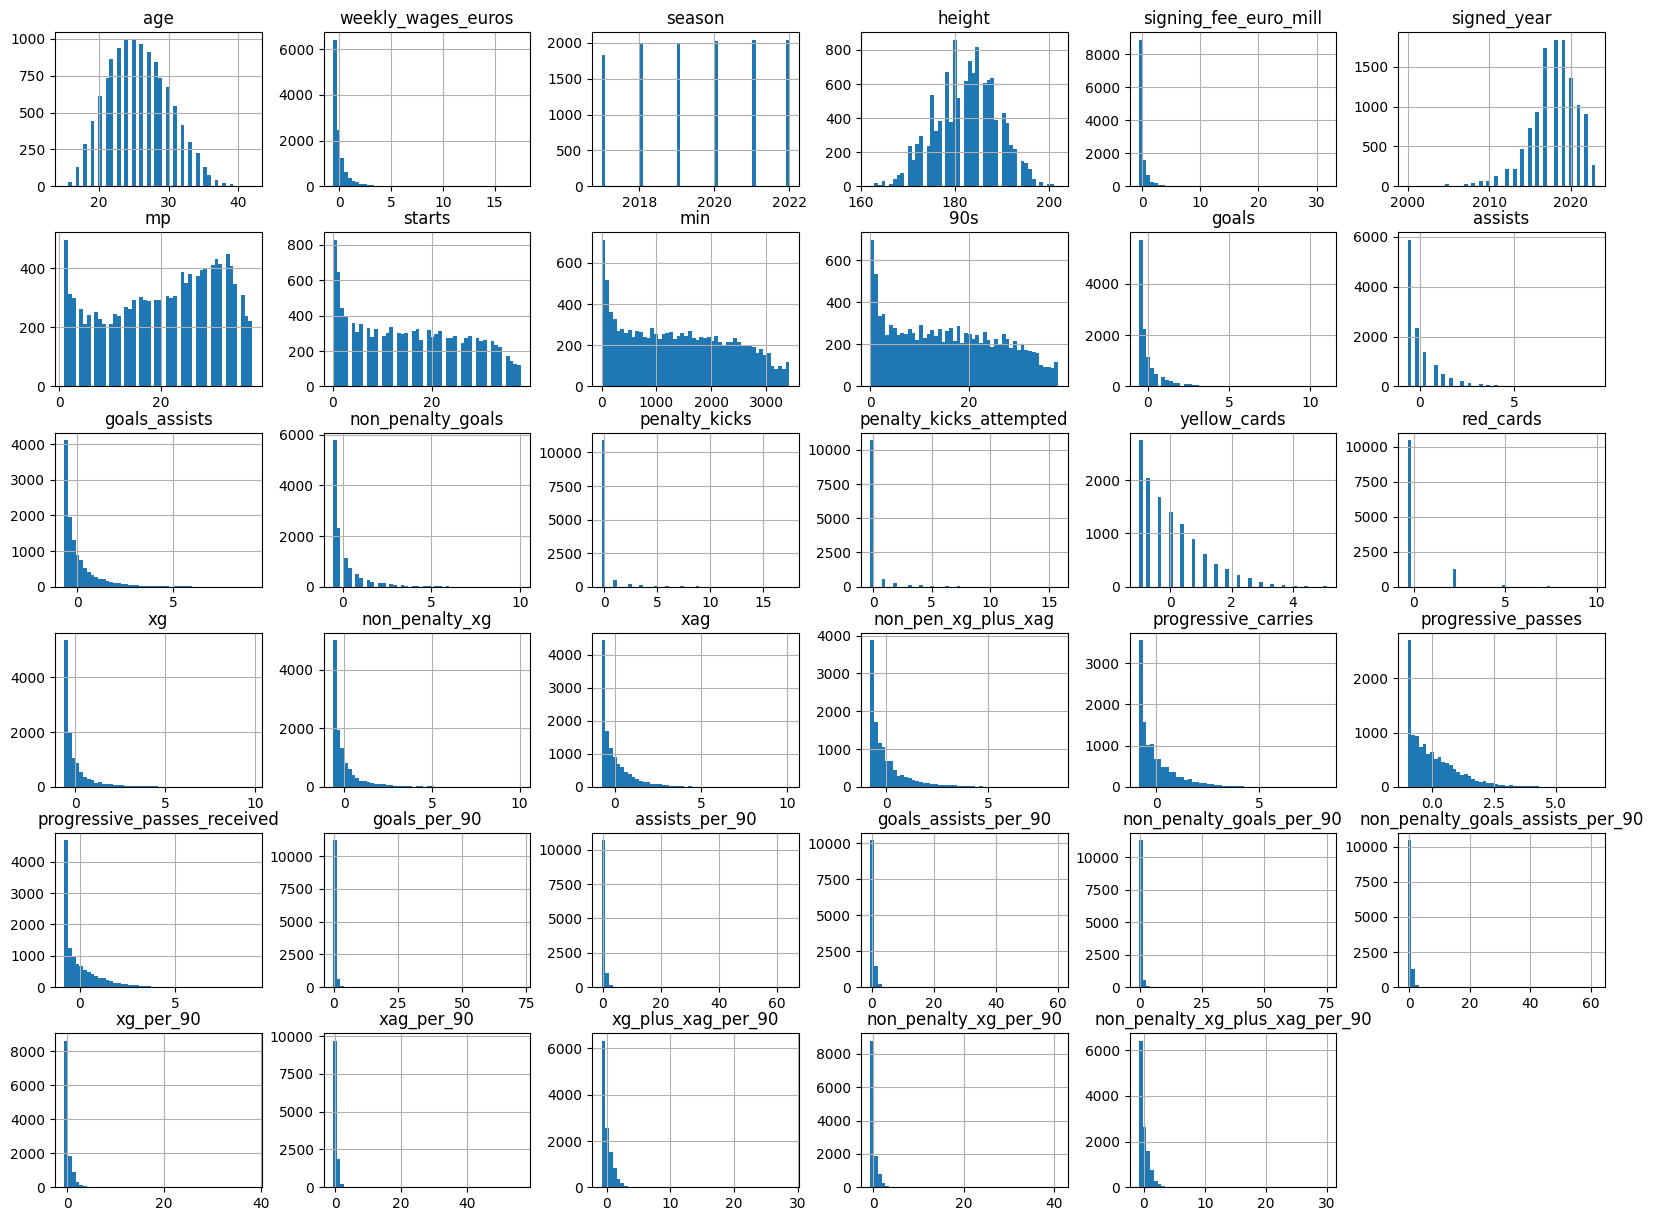

In [47]:
X_train.select_dtypes(include='number').hist(bins=50, figsize=(20, 15))
plt.show()

Based on the initial analysis there are a number of preprocessing steps that need to take place before modelling. These include:
- Fixing data skew and kurtosis
- encoding categorical columns
- drop similiar variables

In [48]:
X_train.head(3)

,squad,age,weekly_wages_euros,season,age_range,continent,position,country,height,foot,signed_from,signing_fee_euro_mill,league,signed_year,mp,starts,min,90s,goals,assists,goals_assists,non_penalty_goals,penalty_kicks,penalty_kicks_attempted,yellow_cards,red_cards,xg,non_penalty_xg,xag,non_pen_xg_plus_xag,progressive_carries,progressive_passes,progressive_passes_received,goals_per_90,assists_per_90,goals_assists_per_90,non_penalty_goals_per_90,non_penalty_goals_assists_per_90,xg_per_90,xag_per_90,xg_plus_xag_per_90,non_penalty_xg_per_90,non_penalty_xg_plus_xag_per_90,is_youth_player
0,Arsenal,28,4.659385,2017,25-29,South America,Centre-Forward,Chile,169.0,right,FC Barcelona,2.200892,premier_league,2014.0,19,17,1503,16.7,1.424459,0.772229,1.334247,1.360058,1.031059,0.817190,0.413769,-0.349931,1.929312,2.014462,1.906091,2.184827,0.802761,1.674156,2.380893,0.979023,0.564100,1.073172,0.837658,0.959583,1.783312,1.466809,2.110791,1.686265,2.047261,False
1,Arsenal,28,4.659385,2017,25-29,Europe,Attacking-Midfield,Germany,180.0,left,Real Madrid,2.491702,premier_league,2013.0,26,24,2163,24.0,0.577121,3.144122,1.734250,0.716684,-0.233415,-0.252354,0.413769,-0.349931,0.761825,0.952512,3.975745,2.403308,3.654679,3.972075,3.097120,0.165698,1.427713,0.804141,0.200937,0.849273,0.245225,1.976649,1.245114,0.311094,1.338865,False
2,Chelsea,26,2.740783,2017,25-29,Europe,Left-Winger,Belgium,175.0,right,LOSC Lille,1.716208,premier_league,2012.0,34,28,2422,26.9,2.836690,1.246607,2.534258,2.646807,2.295534,1.886734,-0.308872,-0.349931,1.803097,1.611654,2.723060,2.281930,5.810198,2.912878,3.608710,1.076622,0.391377,1.046269,0.871169,0.904428,0.790998,1.102639,1.132200,0.575550,1.024022,False


There are too many categorical variables such as player, signed from etc. so need to drop or manipluate these variables before OneHotEncoding these features

In [49]:
X_train.select_dtypes(include='object').columns

Index(['squad', 'age_range', 'continent', 'position', 'country', 'foot',
       'signed_from', 'league', 'is_youth_player'],
      dtype='object')

In [50]:
def create_league_signed_from_col(x: pd.Series) -> bool:
    if pd.isna(x["squad"]) or pd.isna(x["signed_from"]):
        return "False"

    if x["is_youth_player"] == "True":
        return "youth_signing"

    signed_from_words = str(x["signed_from"]).split()  # Split squad name into words

    for word in signed_from_words:
        if word in [
            "Arsenal",
            "Chelsea",
            "Manchester Utd",
            "Manchester City",
            "Southampton",
            "Liverpool",
            "West Brom",
            "Crystal Palace",
            "Everton",
            "West Ham",
            "Tottenham",
            "Leicester City",
            "Swansea City",
            "Watford",
            "Stoke City",
            "Bournemouth",
            "Huddersfield",
            "Burnley",
            "Newcastle Utd",
            "Brighton",
            "Fulham",
            "Wolves",
            "Cardiff City",
            "Aston Villa",
            "Sheffield Utd",
            "Norwich City",
            "Leeds United",
            "Brentford",
            "Nott'ham Forest",
        ]:
            return "premier_league"
        elif word in [
            "Bayern Munich",
            "Dortmund",
            "Wolfsburg",
            "Schalke 04",
            "Leverkusen",
            "Hoffenheim",
            "RB Leipzig",
            "Hamburger SV",
            "Werder Bremen",
            "Köln",
            "Hertha BSC",
            "Eint Frankfurt",
            "Stuttgart",
            "Augsburg",
            "Freiburg",
            "Mainz 05",
            "Düsseldorf",
            "Nürnberg",
            "Union Berlin",
            "Paderborn 07",
            "Arminia",
            "Bochum",
            "Greuther Fürth",
        ]:
            return "bundesliga"
        elif word in [
            "Barcelona",
            "Real Madrid",
            "Atlético Madrid",
            "Levante",
            "Sevilla",
            "Valencia",
            "Villarreal",
            "Athletic Club",
            "Las Palmas",
            "Espanyol",
            "Real Sociedad",
            "Celta Vigo",
            "Girona",
            "La Coruña",
            "Getafe",
            "Eibar",
            "Alavés",
            "Leganés",
            "Rayo Vallecano",
            "Huesca",
            "Granada",
            "Osasuna",
            "Mallorca",
            "Elche",
            "Almería",
        ]:
            return "la_liga"

        elif word in [
            "Milan",
            "Juventus",
            "Inter",
            "Roma",
            "Napoli",
            "Lazio",
            "Genoa",
            "Bologna",
            "Atalanta",
            "Torino",
            "Benevento",
            "Fiorentina",
            "Cagliari",
            "Udinese",
            "Hellas Verona",
            "Chievo",
            "Crotone",
            "Parma",
            "Frosinone",
            "Empoli",
            "Brescia",
            "Lecce",
            "Spezia",
            "Venezia",
            "Sampdoria",
            "Monza",
            "Salernitana",
            "Cremonese",
        ]:
            return "serie_a"

        elif word in [
            "Paris S-G",
            "Monaco",
            "Marseille",
            "Saint-Étienne",
            "Amiens",
            "Lyon",
            "Toulouse",
            "Lille",
            "Rennes",
            "Dijon",
            "Bordeaux",
            "Nantes",
            "Strasbourg",
            "Metz",
            "Guingamp",
            "Montpellier",
            "Caen",
            "Angers",
            "Troyes",
            "Reims",
            "Brest",
            "Lens",
            "Lorient",
            "Nîmes",
            "Clermont Foot",
            "Auxerre",
            "Ajaccio",
        ]:
            return "ligue_1"
        else:
            return "outside_top_5"

- Target encode based on the above
- Do cluster analysis from hands-on book
- Do some principle component analysis - chapter 8 of that book
- create some of the features I listed below I think

- should probably validate the changes based on how the data frame scores when cross-validating

## Data Pipeline

The following classes are custom transformers based on the Scikit-Learn API so that each processor can be implemented in a Scikit-Learn pipeline

drop variables

In [51]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features: list[str]) -> None:
        self.features = features
        self.feature_names_in_ = features

    def fit(self, X: pd.DataFrame, y=None) -> 'DropFeatures':
        X_ = X.copy()
        self.drop_features = X_.drop(self.features, axis=1)
        self.n_features_in_ = X_.shape[1]
        print(self.n_features_in_)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_ = X.copy()
        check_is_fitted(self)
        # assert self.n_features_in_ == X_.shape[1]
        X_ = self.drop_features
        return X_

custom imputer - can groupby other variables in the dataset to get a more accurate imputation, and can impute a column based on a value of another column at the same index.

In [122]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        features: list[str] | str | None = None,
        value: str | None = None,
        strategy: str | None = None,
        groupby: list[str] | None = None,
        impute_by_col: str | None = None,
    ) -> None:
        self.features = features
        self.groupby = groupby
        self.strategy = strategy
        self.value = value
        self.impute_by_col = impute_by_col

    def _groupby_impute(self, X: pd.DataFrame) -> np.ndarray:
        X_ = X.copy()
        transformed_cols = [] 
        for col in X_.columns:
            if X_[col].isnull().sum() > 0 and X_[col].dtype == 'number':
                transformed_cols.append(col)
                X_.loc[:, col] = X_[col].fillna(
                    X_.groupby(self.groupby)[col].transform(self.strategy)
                )
        if len(transformed_cols) > 1:
            values = X_[transformed_cols].to_numpy()
        else:
            values = X_[transformed_cols].to_numpy().reshape(-1, 1)
            
        return values

    def _fillna_impute(self, X: pd.DataFrame) -> np.ndarray:
        X_ = X.copy()
        if not self.impute_by_col:
            X_.loc[:, self.features] = X_[self.features].fillna(self.value)
        else:
            X_.loc[:, self.features] = X_[self.features].fillna(X_[self.impute_by_col])
        return X_[self.features].to_numpy().reshape(-1, 1) 

    def fit(self, X: pd.DataFrame, y=None) -> "CustomImputer":
        if self.strategy:
            self.impute_ = self._groupby_impute(X)
        else:
            self.impute_ = self._fillna_impute(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        check_is_fitted(self)
        assert self.n_features_in_ == X.shape[1]
        return self.impute_
    
    def get_feature_names_out(self, names=None) -> list[str]:
        return self.features

custom class to apply function to dataframe using the Pandas .apply() method

In [120]:
class ApplyFunction(BaseEstimator, TransformerMixin):
    def __init__(self, feature: str, apply_func: Callable):
        self.feature = feature
        self.apply_func = apply_func

    def fit(self, X: pd.DataFrame, y=None) -> "ApplyFunction":
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        check_is_fitted(self)
        # assert self.n_features_in_ == X.shape[1]
        X_ = X.apply(self.apply_func, axis=1)
        return X_.to_numpy().reshape(-1, 1)
    
    def get_feature_names_out(self, names=None) -> str:
        return self.feature

Another imputer which imputes a column which a specified value based on the condition of another variable. For example, when is_youth_player == True, set signing_fee as 0.

In [119]:
class BoolImputer(BaseEstimator, TransformerMixin):
    def __init__(
        self, feature: str, value: int, condition_col: str, condition: bool
    ) -> None:
        self.feature = feature
        self.value = value
        self.condition_col = condition_col
        self.condition = condition

    def fit(self, X: pd.DataFrame, y=None) -> "BoolImputer":
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        check_is_fitted(self)
        assert self.n_features_in_ == X.shape[1]
        X.loc[X[self.condition_col] == self.condition, self.feature] = self.value
        return X[self.feature].to_numpy().reshape(-1, 1)
    
    def get_feature_names_out(self, names=None) -> str:
        return self.feature

Custom Log Transformer

In [102]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, log_type: str) -> None:
        self.log_type = log_type

    def fit(self, X: pd.DataFrame, y=None) -> "LogTransformer":
        check_array(X)
        self.n_features_in_ = X.shape[1]
        self.features_names_in_ = X.columns
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        check_is_fitted(self)
        check_array(X)
        assert self.n_features_in_ == X.shape[1]

        if self.log_type == "log":
            X_log = np.log(X)
        elif self.log_type == "log10":
            X_log = np.log10(X)
        else:
            X_log = np.log1p(X)
        return X_log

    def inverse_transform(self, X: pd.DataFrame) -> np.ndarray:
        assert self.n_features_in_ == X.shape[1]

        if self.log_type == "log":
            X_inv = np.exp(X)
        elif self.log_type == "log10":
            X_inv = 10**X
        else:
            X_inv = np.expm1(X)
        return X_inv
    
    def get_feature_names_out(self, names=None) -> str:
        return self.features_names_in_

## Feature Engineering

Both the functions below will be employed using the ApplyFunction() class

Function to create a penalty taker column

In [103]:
def create_penalty_taker_col(x: pd.Series) -> bool:
    if x["penalty_kicks_attempted"] > 0:
        return 'True'
    else:
        return 'False'

Function to create a year since signed column

In [104]:
def create_years_since_signed_col(x: pd.Series) -> int:
    return x['season'] - x['signed_year']

Custom clustering class that uses KMeans and rbf_kernel to find appropriate clusters - taken directly from Hands-on machine learning by Aurelien Geron

In [105]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(
        self, n_clusters: int = 10, gamma: float = 1, random_state: int = 42
    ) -> None:
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X: pd.DataFrame, y=None, sample_weight=None) -> "ClusterSimilarity":
        check_array(X)
        self.n_features_in_ = X.shape[1]
        self.kmeans_ = KMeans(
            n_clusters=self.n_clusters, random_state=self.random_state, n_init=10
        )
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        check_is_fitted(self)
        check_array(X)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None) -> list[str]:
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

Custom PCA class - don't think it really does anything different to the base PCA() class

In [106]:
class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, standardise: bool = True, n_components: int = 0.95) -> None:
        self.standardise = standardise
        self.n_components = n_components

    def fit(self, X: pd.DataFrame, y=None) -> "CustomPCA":
        check_array(X)
        self.n_features_in_ = X.shape[1]
        self.pca_ = PCA(n_components=self.n_components)
        self.pca_.fit(X)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        check_is_fitted(self)
        check_array(X)

        if self.standardise:
            X = (X - X.mean()) / X.std(axis=0)
            
        return self.pca_.transform(X)

    def get_feature_names_out(self, names=None) -> list[str]:
        return [f"PC {i}" for i in range(self.pca_.n_components_)]

FunctionTransformer used for a log transformation - secondary option to the custom LogTransformer() class

In [107]:
log_transformer = FunctionTransformer(np.log1p, validate=True, inverse_func=np.expm1, feature_names_out='one-to-one')

Initiate each preprocessing step

In [123]:
# drop_features = DropFeatures(features=cols_to_drop)

# youth_player_feat = ApplyFunction(
#     feature="is_youth_player",
#     apply_func=create_youth_player_col,
# )

youth_player = FunctionTransformer(create_youth_player_col, validate=False, feature_names_out='one-to-one')
league_signed_from = FunctionTransformer(create_league_signed_from_col, validate=False, feature_names_out='one-to-one')
penalty_taker = FunctionTransformer(create_penalty_taker_col, validate=False, feature_names_out='one-to-one')
year_since_signed = FunctionTransformer(create_years_since_signed_col, validate=False, feature_names_out='one-to-one')

# league_signed_from_feat = ApplyFunction(
#     feature="league_signed_from",
#     apply_func=create_league_signed_from_col,
# )

signed_from_impute = CustomImputer(features="signed_from", value="Unknown")

signed_year_impute = CustomImputer(features="signed_year", impute_by_col="season")


# pen_taker_feat = ApplyFunction(
#     feature="is_penalty_taker", apply_func=create_penalty_taker_col
# )
# year_since_signed_feat = ApplyFunction(
#     feature="years_since_signed", apply_func=create_years_since_signed_col
# )

signing_fee_imputer_1 = BoolImputer(
    feature="signing_fee_euro_mill",
    value=0,
    condition_col="is_youth_player",
    condition=True,
)

values_imputer = CustomImputer(
    features=["signing_fee_euro_mill"],
    groupby=["league", "age_range"],
    strategy="median",
)

stats_imputer = CustomImputer(
    groupby=["league", "age_range", "position"],
    strategy="median",
)

cols_to_drop = [
    "player_id",
    "rk",
    "general_pos",
    "pos",
    "nation",
    "comp",
    "born",
    "annual_wages_euros",
    "player",
    "age_range",
]

# drop_features = DropFeatures(features=cols_to_drop)

# def drop_columns(X: pd.DataFrame) -> pd.DataFrame:
#     return X.drop(, axis=1)

In [109]:
num_pipeline = make_pipeline(
    StandardScaler()
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False),
)

target_pipeline = make_pipeline(
    TargetEncoder(cols=['squad', 'country', 'signed_from']),
)

In [110]:
preprocessor = make_pipeline(
    # youth_player_feat,
    # pen_taker_feat,
    # league_signed_from_feat,
    signed_from_impute,
    signed_year_impute,
    signing_fee_imputer_1,
    # year_since_signed_feat,
    values_imputer,
    stats_imputer,
    # drop_age_range, 
    # drop_features,
    verbose=True,
)

preprocessor

Pipeline(steps=[('customimputer-1',
                 CustomImputer(features='signed_from', value='Unknown')),
                ('customimputer-2',
                 CustomImputer(features='signed_year', impute_by_col='season')),
                ('boolimputer',
                 BoolImputer(condition=True, condition_col='is_youth_player',
                             feature='signing_fee_euro_mill', value=0)),
                ('customimputer-3',
                 CustomImputer(features=['signing_fee_euro_mill'],
                               groupby=['league', 'age_range'],
                               strategy='median')),
                ('customimputer-4',
                 CustomImputer(groupby=['league', 'age_range', 'position'],
                               strategy='median'))],
         verbose=True)

In [111]:
target_cols = ["squad", "country", "signed_from"]
cat_cols = [
    col
    for col in X_train.select_dtypes(include="object").columns
    if col not in target_cols + cols_to_drop + ["age_range"]
]

In [112]:
stat_imputer_cols = X_train.select_dtypes(include="number").columns.tolist() + [
    "league",
    "age_range",
    "position",
]

In [142]:
preprocessor = ColumnTransformer(
    [
        (
            "customimpute1",
            signed_from_impute,
            ["signed_from"],
        ),
        (
            "customimpute2",
            signed_year_impute,
            ["signed_year", "season"],
        ),
        (
            "boolimpute1",
            signing_fee_imputer_1,
            ["signing_fee_euro_mill", "is_youth_player"],
        ),
        # (
        #     "customimpute3",
        #     values_imputer,
        #     ["signing_fee_euro_mill", "league", "age_range"],
        # ),
        ("customimputer4", stats_imputer, stat_imputer_cols),
    ],
    verbose=True,
)

In [143]:
preprocessor.fit_transform(X_train)

[ColumnTransformer] . (1 of 3) Processing customimpute1, total=   0.0s
[ColumnTransformer] . (2 of 3) Processing customimpute2, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing boolimpute1, total=   0.0s


array([['FC Barcelona', 2014.0, 2.200891875435884],
       ['Real Madrid', 2013.0, 2.4917021568834503],
       ['LOSC Lille', 2012.0, 1.716208073023274],
       ...,
       ['Olympique Marseille', 2021.0, -0.5456496715689074],
       ['AC Ajaccio B', 2020.0, -0.4164006575922114],
       ['Clermont Foot 63 B', 2018.0, -0.35177615060386336]], dtype=object)

In [ ]:
417130/ 11918

35.0

In [ ]:
preprocessor.get_feature_names_out()

array([], dtype=object)

In [ ]:

transformer = ColumnTransformer(
    [
        ('is_youth_player', youth_player, ['squad', 'signed_from']),
        ('league_signed_from', league_signed_from, ['signed_from', 'squad', 'is_youth_player']),
        ('is_pen_taker', penalty_taker, ['penalty_kicks_attempted']),
        ('year_since_signed', year_since_signed, ['season', 'signed_year']),
        ('target', target_pipeline, target_cols), 
        ("num", num_pipeline, make_column_selector(dtype_include="number")),
        ('cat', cat_pipeline, cat_cols),
        ("clust", ClusterSimilarity(n_clusters=5), ["age", "weekly_wages_euros"]),
        ("pca", PCA(), ["age", "weekly_wages_euros"]),
    ],
    verbose=True,
    remainder=OneHotEncoder(handle_unknown='ignore', sparse_output=False),
)

transformer

ColumnTransformer(remainder=OneHotEncoder(handle_unknown='ignore',
                                          sparse_output=False),
                  transformers=[('is_youth_player',
                                 FunctionTransformer(func=<function create_youth_player_col at 0x3088594e0>),
                                 ['squad', 'signed_from']),
                                ('league_signed_from',
                                 FunctionTransformer(func=<function create_league_signed_from_col at 0x305e1ba60>),
                                 ['signed_from', 'squad', 'is_yout...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x30645d220>),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['continent', 'position', 'foot', 'league',
                                  'is_youth_player']),
                                ('clust', ClusterSimilarity(n_clusters=5),
                                 ['age', 'weekly_wages_euros']),
                                ('pca', PCA(), ['age', 'weekly_wages_euros'])],
                  verbose=True)

In [ ]:
full_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        # ("engineering", feature_creation),
        ("transformer", transformer),
    ],
    verbose=True,
    # memory='cache'
)
full_pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('applyfunction-1',
                                  ApplyFunction(apply_func=<function create_youth_player_col at 0x3088594e0>,
                                                feature='is_youth_player')),
                                 ('applyfunction-2',
                                  ApplyFunction(apply_func=<function create_league_signed_from_col at 0x305e1ba60>,
                                                feature='league_signed_from')),
                                 ('customimputer-1',
                                  CustomImputer(features='signed_from'...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['continent', 'position',
                                                   'foot', 'league',
                                                   'is_youth_player']),
                                                 ('clust',
                                                  ClusterSimilarity(n_clusters=5),
                                                  ['age',
                                                   'weekly_wages_euros']),
                                                 ('pca', PCA(),
                                                  ['age',
                                                   'weekly_wages_euros'])],
                                   verbose=True))],
         verbose=True)

In [ ]:
X = class_df.drop('market_value_euro_mill', axis=1)
y = class_df['market_value_euro_mill']

In [ ]:
# dff = pd.DataFrame(
#     full_pipeline.fit_transform(X, y),
#     columns=full_pipeline["transformer"].get_feature_names_out(),
# )

Combine the preprocessing steps with TransformedTargetRegressor

In [ ]:
def regressor_pipeline(model: RegressorMixin) -> Pipeline:
    return make_pipeline(
        full_pipeline,
        model,
        verbose=True,
        # memory='cache'
    )

In [ ]:
def target_pipeline() -> Pipeline:
    return make_pipeline(
        LogTransformer(log_type='log10'),
        verbose=True,
        # memory='cache'
    )

Impute y before running in pipeline as the TransformedTargetRegressor does not seem to handle imputation for the target variable

In [ ]:
pipeline = TransformedTargetRegressor(
    transformer=target_pipeline(),
    regressor=regressor_pipeline(model=RandomForestRegressor()),
    check_inverse=False,
)

In [ ]:
train_set = class_df.loc[class_df['season'] != 2023]
season_2023 = class_df.loc[class_df['season'] == 2023]
valid_set, test_set = train_test_split(season_2023, test_size=0.5, stratify=season_2023['position'], random_state=42)

In [ ]:
X_train, y_train = train_set.drop('market_value_euro_mill', axis=1), train_set['market_value_euro_mill']

In [ ]:
# pipeline.fit(X_train, y_train)

[Pipeline] .... (step 1 of 1) Processing logtransformer, total=   0.0s
[Pipeline] ... (step 1 of 8) Processing applyfunction-1, total=   0.1s
[Pipeline] ... (step 2 of 8) Processing applyfunction-2, total=   0.1s
[Pipeline] ... (step 3 of 8) Processing customimputer-1, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing customimputer-2, total=   0.0s
[Pipeline] ....... (step 5 of 8) Processing boolimputer, total=   0.0s
[Pipeline] ... (step 6 of 8) Processing customimputer-3, total=   0.0s
[Pipeline] ... (step 7 of 8) Processing customimputer-4, total=   0.0s
54
[Pipeline] ...... (step 8 of 8) Processing dropfeatures, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.2s
[Pipeline] ....... (step 2 of 3) Processing engineering, total=   0.1s
[ColumnTransformer] ........ (1 of 6) Processing target, total=   0.0s
[ColumnTransformer] ........... (2 of 6) Processing num, total=   0.0s
[ColumnTransformer] ........... (3 of 6) Processing cat, total=   0.0s


[ColumnTransformer] ......... (4 of 6) Processing clust, total=   0.9s
[ColumnTransformer] ........... (5 of 6) Processing pca, total=   0.0s
[ColumnTransformer] ..... (6 of 6) Processing remainder, total=   0.0s
[Pipeline] ....... (step 3 of 3) Processing transformer, total=   0.9s
[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.2s
[Pipeline]  (step 2 of 2) Processing randomforestregressor, total=  16.2s
[Pipeline]  (step 1 of 1) Processing transformedtargetregressor, total=  17.4s


Pipeline(steps=[('transformedtargetregressor',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(steps=[('pipeline',
                                                                       Pipeline(steps=[('preprocessor',
                                                                                        Pipeline(steps=[('applyfunction-1',
                                                                                                         ApplyFunction(apply_func=<function create_youth_player_col at 0x3088594e0>,
                                                                                                                       feature='is_youth_player')),
                                                                                                        ('applyfunction-2',
                                                                                                         ApplyFunction(apply_func=<functio...
                                                                                                                          'league',
                                                                                                                          'is_youth_player']),
                                                                                                                        ('clust',
                                                                                                                         ClusterSimilarity(n_clusters=5),
                                                                                                                         ['age',
                                                                                                                          'weekly_wages_euros']),
                                                                                                                        ('pca',
                                                                                                                         PCA(),
                                                                                                                         ['age',
                                                                                                                          'weekly_wages_euros'])],
                                                                                                          verbose=True))],
                                                                                verbose=True)),
                                                                      ('randomforestregressor',
                                                                       RandomForestRegressor())],
                                                               verbose=True),
                                            transformer=Pipeline(steps=[('logtransformer',
                                                                         LogTransformer(log_type='log10'))],
                                                                 verbose=True)))],
         verbose=True)

TODO:
- Cross validate model
- tune paramaters on validation set - include PCA tuning
- test tuned model on test set
- move code to .py script for production

## Cross-validate model

In [ ]:
X_valid = valid_set.drop('market_value_euro_mill', axis=1)
y_valid = valid_set['market_value_euro_mill'].copy()

In [ ]:
X_train.shape, y_train.shape

((11918, 54), (11918,))

In [ ]:
new_pipe = make_pipeline(
    full_pipeline,
    RandomForestRegressor(),
    verbose=True,
    # memory='cache'
)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)

[Pipeline] ... (step 1 of 8) Processing applyfunction-1, total=   0.1s
[Pipeline] ... (step 1 of 8) Processing applyfunction-1, total=   0.1s
[Pipeline] ... (step 1 of 8) Processing applyfunction-1, total=   0.1s
[Pipeline] ... (step 1 of 8) Processing applyfunction-1, total=   0.1s
[Pipeline] ... (step 1 of 8) Processing applyfunction-1, total=   0.1s
[Pipeline] ... (step 2 of 8) Processing applyfunction-2, total=   0.1s
[Pipeline] ... (step 2 of 8) Processing applyfunction-2, total=   0.1s
[Pipeline] ... (step 3 of 8) Processing customimputer-1, total=   0.0s
[Pipeline] ... (step 2 of 8) Processing applyfunction-2, total=   0.1s
[Pipeline] ... (step 4 of 8) Processing customimputer-2, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing customimputer-1, total=   0.0s
[Pipeline] ... (step 2 of 8) Processing applyfunction-2, total=   0.1s
[Pipeline] ....... (step 5 of 8) Processing boolimputer, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing customimputer-2, total=   0.0s
[Pipel

ValueError: Found input variables with inconsistent numbers of samples: [2383, 9535]

In [ ]:
# 9534 divided by 2384
11918 / 2383

5.0012589173310955